# INFO 4900 — Week Three

In [55]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import re
import joblib
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from geopandas import GeoSeries

## Preparing Data

In [4]:
# Load data
polls = gpd.read_feather("data/polling_station_coords.feather")
districts = gpd.read_file("data/Uganda_Districts-2020---136-wgs84.zip")
names = pd.read_feather("data/names_with_kingdoms.feather")

## Sanitizing Text: polling_station_coords.feather

In [5]:
# Stripping whitespace
polls['PS_name'] = polls['PS_name'].str.strip()

In [6]:
# Lowering case
polls['PS_name'] = polls['PS_name'].str.lower()

In [7]:
# Removing special characters
polls['PS_name'] = polls['PS_name'].str.replace('[^\w\s]', '', True)

/var/folders/33/qp5k0v8128136rvjkr63g0x00000gn/T/ipykernel_7660/2074057513.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  polls['PS_name'] = polls['PS_name'].str.replace('[^\w\s]', '', True)


In [8]:
# Second look at dataframe
polls.head()

,PS_name,PS_code,VoteReg_district_name,VoteReg_district_code,VoteReg_county_name,VoteReg_county_code,VoteReg_subcounty_name,VoteReg_subcounty_code,VoteReg_parish_code,VoteReg_parish_name,...,FDC_Registered,Turnout,REG_VOTERS,YOWERI_KAGUTA_MUSEVENI,KIZZA_BESIGYE_KIFEFE,VALID_VOTES,village_mean_distance,villages,lat_lon,points
0,adyeda centre,1,APAC,1,KWANIA COUNTY,2,ADUKU,1,1,ADYEDA,...,0.115523,0.671480,277.0,144.0,32.0,182.0,2285.087273,ADYEDA IMALO;ANYWAL;ATAKARA;,"[2.065772095790027, 32.715481326735095]",POINT (32.71548 2.06577)
1,aporwegi ps,2,APAC,1,KWANIA COUNTY,2,ADUKU,1,1,ADYEDA,...,0.146724,0.646724,702.0,283.0,103.0,430.0,1127.896277,ADYEDA IMALO;ANYWAL;APORWEGI AATAKARA,"[2.058047456592412, 32.72281709757338]",POINT (32.72282 2.05805)
2,adyeda imalo,3,APAC,1,KWANIA COUNTY,2,ADUKU,1,1,ADYEDA,...,0.137072,0.753894,321.0,190.0,44.0,238.0,1921.654206,ADYEDA IMALO;ANYWAL,"[2.065772095790027, 32.715481326735095]",POINT (32.71548 2.06577)
3,alira b,1,APAC,1,KWANIA COUNTY,2,ADUKU,1,2,ALIRA,...,0.266055,0.694954,872.0,328.0,232.0,584.0,1695.521839,AKOT A;AKOT B;AKWODONG B;AKWOYO;ALIRA A;ALIRA ...,"[2.0821059545915097, 32.761479779076204]",POINT (32.76148 2.08211)
4,akot a,2,APAC,1,KWANIA COUNTY,2,ADUKU,1,2,ALIRA,...,0.344000,0.682667,750.0,218.0,258.0,504.0,1653.587131,AKOT A;AKOT B;AKWODONG A;AKWODONG B;AKWOYO;ALI...,"[2.042473960840479, 32.742188123783855]",POINT (32.74219 2.04247)


## Sanitizing Text: names_with_kingdoms.feather

In [9]:
# Stripping whitespace
names['polling_station'] = names['polling_station'].str.strip()

In [10]:
# Lowering case
names['polling_station'] = names['polling_station'].str.lower()

In [11]:
# Removing special characters
names['polling_station'] = names['polling_station'].str.replace('[^\w\s]', '', True)

/var/folders/33/qp5k0v8128136rvjkr63g0x00000gn/T/ipykernel_7660/820029302.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  names['polling_station'] = names['polling_station'].str.replace('[^\w\s]', '', True)


In [12]:
# Second look at dataframe
names.head()

,Unnamed: 0,appid_receipt_num,constituency,constituency_num,date_of_birth,district,district_num,other_name,parish,parish_num,polling_station,polling_station_num,sex,sub_county,sub_county_num,surname,village,voter_num,d_names,region
0,0,1206420000MP6/CF8407,KWANIA COUNTY,2,26-12-1984,Apac,1,CHRISTINE,ADYEDA,1,adyeda centre,1,F,ADUKU,1,ABANG,ANYWAL,61281069,Apac,Lango
1,1,0906720000RKU/CF4900,KWANIA COUNTY,2,10-05-1949,Apac,1,BITU,ADYEDA,1,adyeda centre,1,F,ADUKU,1,ABEJA,ATAKARA,58687089,Apac,Lango
2,2,1025320003CZW/CM910,KWANIA COUNTY,2,07-07-1991,Apac,1,JACOB,ADYEDA,1,adyeda centre,1,M,ADUKU,1,ABILI,ADYEDA IMALO,55386251,Apac,Lango
3,3,1328720001XLP/CF8200,KWANIA COUNTY,2,16-03-1982,Apac,1,JENIFFER,ADYEDA,1,adyeda centre,1,F,ADUKU,1,ABUNI,ANYWAL,64284712,Apac,Lango
4,4,0906720000UV6/CF7500,KWANIA COUNTY,2,05-05-1975,Apac,1,EVALINE,ADYEDA,1,adyeda centre,1,F,ADUKU,1,ABWOLI,ATAKARA,63056778,Apac,Lango


## Maps of Polling Station Data

In [13]:
# Explore district data format
districts.head()

,dname2019,d,total2020,ttotal2020,2010,2016,2017,2018,2020,geometry
0,MASAKA,Masaka,"335,700",335700.0,MASAKA,MASAKA,MASAKA,MASAKA,MASAKA,"POLYGON ((32.00051 -0.60761, 32.00053 -0.60993..."
1,BUTEBO,Butebo,"121,200",121200.0,PALLISA,BUTEBO,BUTEBO,BUTEBO,BUTEBO,"POLYGON ((33.87314 1.22742, 33.87306 1.22897, ..."
2,ALEBTONG,Alebtong,"266,100",266100.0,ALEBTONG,ALEBTONG,ALEBTONG,ALEBTONG,ALEBTONG,"POLYGON ((33.44290 2.36391, 33.44264 2.36336, ..."
3,TORORO,Tororo,"597,500",597500.0,TORORO,TORORO,TORORO,TORORO,TORORO,"POLYGON ((33.97873 0.57800, 33.97864 0.57808, ..."
4,MOROTO,Moroto,"118,500",118500.0,MOROTO,MOROTO,MOROTO,MOROTO,MOROTO,"POLYGON ((34.83133 2.16438, 34.83133 2.16438, ..."


<AxesSubplot:>

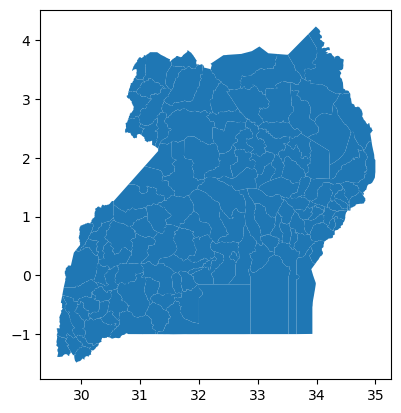

In [14]:
# Create a sample map
districts.plot()

In [15]:
# Spatially join polling and district datasets
polls = polls.set_crs(epsg=4326, inplace=True)
joined_df = gpd.sjoin(districts, polls, how = "left", op = "intersects")

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [16]:
# Explore joined data values
joined_df.head()

,dname2019,d,total2020,ttotal2020,2010,2016,2017,2018,2020,geometry,...,NRM_Registered,FDC_Registered,Turnout,REG_VOTERS,YOWERI_KAGUTA_MUSEVENI,KIZZA_BESIGYE_KIFEFE,VALID_VOTES,village_mean_distance,villages,lat_lon
0,MASAKA,Masaka,"335,700",335700.0,MASAKA,MASAKA,MASAKA,MASAKA,MASAKA,"POLYGON ((32.00051 -0.60761, 32.00053 -0.60993...",...,0.259084,0.396524,0.733017,633.0,164.0,251.0,452.0,784.993681,KALAGALA;LWABIKERE;MULEMA,"[-0.28158847509456986, 31.77385129072259]"
0,MASAKA,Masaka,"335,700",335700.0,MASAKA,MASAKA,MASAKA,MASAKA,MASAKA,"POLYGON ((32.00051 -0.60761, 32.00053 -0.60993...",...,0.213693,0.441909,0.695021,482.0,103.0,213.0,333.0,209.000000,KAYUNGA,"[-0.2785289074682445, 31.74929731060801]"
0,MASAKA,Masaka,"335,700",335700.0,MASAKA,MASAKA,MASAKA,MASAKA,MASAKA,"POLYGON ((32.00051 -0.60761, 32.00053 -0.60993...",...,0.371795,0.311355,0.745421,546.0,203.0,170.0,386.0,413.977099,BUGABIRAKIYIMBWEKYALUGO;NDEGEYA,"[-0.27458103041014326, 31.726929432861564]"
0,MASAKA,Masaka,"335,700",335700.0,MASAKA,MASAKA,MASAKA,MASAKA,MASAKA,"POLYGON ((32.00051 -0.60761, 32.00053 -0.60993...",...,0.334821,0.252232,0.649554,448.0,150.0,113.0,276.0,3515.906250,KAKO HILL;KAKO VILLAGE;NAMAKINDU,"[-0.27043467917998293, 31.81306674535471]"
0,MASAKA,Masaka,"335,700",335700.0,MASAKA,MASAKA,MASAKA,MASAKA,MASAKA,"POLYGON ((32.00051 -0.60761, 32.00053 -0.60993...",...,0.331723,0.347826,0.698873,621.0,206.0,216.0,432.0,2694.376812,KINYERERE;LWANDA;NAKATOOKE,"[-0.2701900045230249, 31.7965600827924]"


In [17]:
# Group by district name and count polling stations
poll_count = joined_df.groupby("2016")["2016"].count()
poll_count.name = "poll_count"
districts = pd.merge(left = districts, right = poll_count, left_on = "2016", right_index = True)

0        Annotation(31.8556, -0.491258, 'MASAKA')
1          Annotation(33.9843, 1.18223, 'BUTEBO')
2        Annotation(33.2557, 2.26668, 'ALEBTONG')
3         Annotation(34.0822, 0.724974, 'TORORO')
4          Annotation(34.6316, 2.64869, 'MOROTO')
                          ...                    
124         Annotation(31.6614, -0.8062, 'RAKAI')
126       Annotation(31.3037, -0.707012, 'RAKAI')
125        Annotation(31.7027, 0.195672, 'GOMBA')
127    Annotation(30.1518, -0.483758, 'BUSHENYI')
128    Annotation(30.8777, -0.853239, 'ISINGIRO')
Length: 136, dtype: object

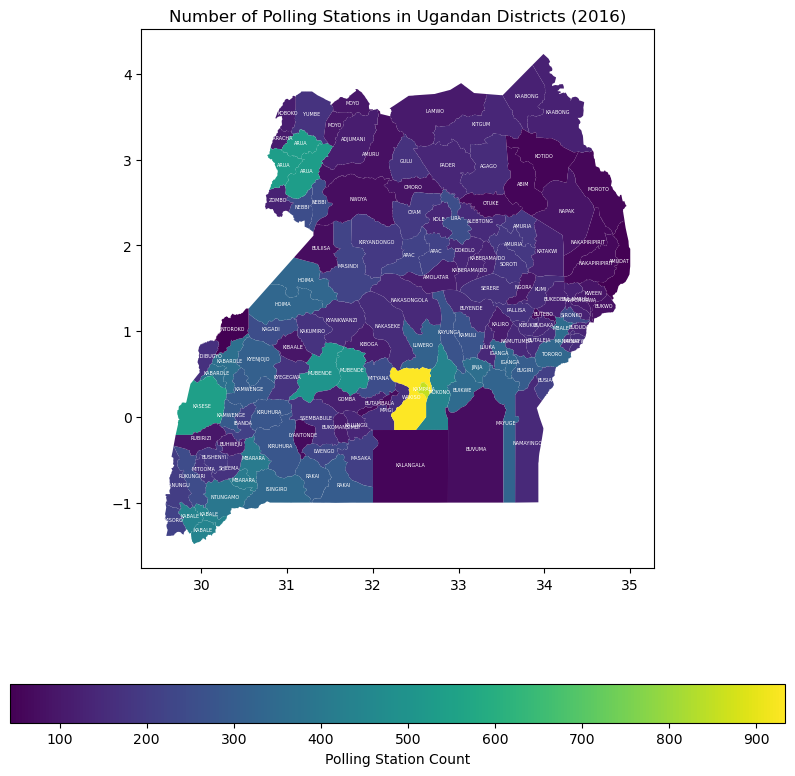

In [18]:
# Graph number of polling stations (labels)
ax = districts.plot(column = "poll_count",
                    cmap = "viridis",
                    legend = True,
                    legend_kwds={'label': "Polling Station Count",
                                'orientation': "horizontal"},
                    figsize = (10,10))
ax.set_title('Number of Polling Stations in Ugandan Districts (2016)')
districts.apply(lambda x: ax.annotate(text=x["2016"], xy = x.geometry.centroid.coords[0], ha = 'center', fontsize = 3.5, color = 'white'), axis = 1)

In [19]:
# Group by district name and count voters
voter_count = joined_df.groupby("2016")["REG_VOTERS"].sum()
voter_count.name = "voter_count"
districts = pd.merge(left = districts, right = voter_count, left_on = "2016", right_index = True)

0        Annotation(31.8556, -0.491258, 'MASAKA')
1          Annotation(33.9843, 1.18223, 'BUTEBO')
2        Annotation(33.2557, 2.26668, 'ALEBTONG')
3         Annotation(34.0822, 0.724974, 'TORORO')
4          Annotation(34.6316, 2.64869, 'MOROTO')
                          ...                    
124         Annotation(31.6614, -0.8062, 'RAKAI')
126       Annotation(31.3037, -0.707012, 'RAKAI')
125        Annotation(31.7027, 0.195672, 'GOMBA')
127    Annotation(30.1518, -0.483758, 'BUSHENYI')
128    Annotation(30.8777, -0.853239, 'ISINGIRO')
Length: 136, dtype: object

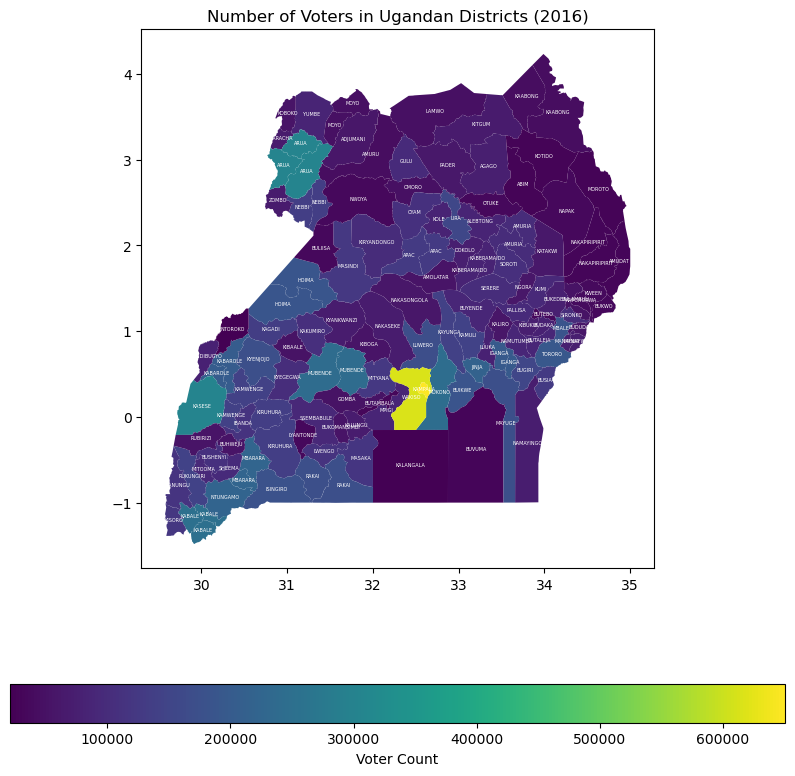

In [20]:
# Graph number of voters (labels)
ax1 = districts.plot(column = "voter_count",
                    cmap = "viridis",
                    legend = True,
                    legend_kwds={'label': "Voter Count",
                                'orientation': "horizontal"},
                    figsize = (10,10))
ax1.set_title('Number of Voters in Ugandan Districts (2016)')
districts.apply(lambda x: ax1.annotate(text=x["2016"], xy = x.geometry.centroid.coords[0], ha = 'center', fontsize = 3.5, color = 'white'), axis = 1)

In [21]:
# Group by district name and calculate voters per station
voter_ratio = voter_count/poll_count
voter_ratio.name = "voter_ratio"
districts = pd.merge(left = districts, right = voter_ratio, left_on = "2016", right_index = True)

0        Annotation(31.8556, -0.491258, 'MASAKA')
1          Annotation(33.9843, 1.18223, 'BUTEBO')
2        Annotation(33.2557, 2.26668, 'ALEBTONG')
3         Annotation(34.0822, 0.724974, 'TORORO')
4          Annotation(34.6316, 2.64869, 'MOROTO')
                          ...                    
124         Annotation(31.6614, -0.8062, 'RAKAI')
126       Annotation(31.3037, -0.707012, 'RAKAI')
125        Annotation(31.7027, 0.195672, 'GOMBA')
127    Annotation(30.1518, -0.483758, 'BUSHENYI')
128    Annotation(30.8777, -0.853239, 'ISINGIRO')
Length: 136, dtype: object

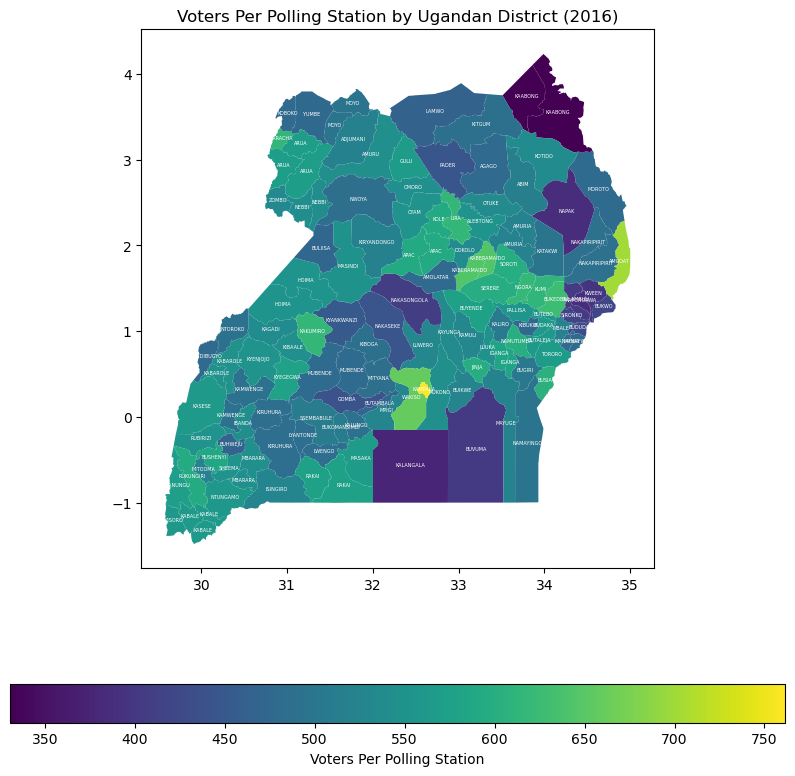

In [22]:
# Graph voter-to-station ratio (labels)
ax2 = districts.plot(column = "voter_ratio",
                    cmap = "viridis",
                    legend = True,
                    legend_kwds={'label': "Voters Per Polling Station",
                                'orientation': "horizontal"},
                    figsize = (10,10))
ax2.set_title('Voters Per Polling Station by Ugandan District (2016)')
districts.apply(lambda x: ax2.annotate(text=x["2016"], xy = x.geometry.centroid.coords[0], ha = 'center', fontsize = 3.5, color = 'white'), axis = 1)

## Preliminary Merge

In [23]:
# Merge polling station and voter dataframes
merged_df = pd.merge(polls, names, left_on = "PS_name", right_on = "polling_station", how = "outer", indicator = True)

In [24]:
# Quick look at merged data
print(merged_df)

                PS_name  PS_code VoteReg_district_name  VoteReg_district_code  \
0         adyeda centre      1.0                  APAC                    1.0   
1         adyeda centre      1.0                  APAC                    1.0   
2         adyeda centre      1.0                  APAC                    1.0   
3         adyeda centre      1.0                  APAC                    1.0   
4         adyeda centre      1.0                  APAC                    1.0   
...                 ...      ...                   ...                    ...   
15400869            NaN      NaN                   NaN                    NaN   
15400870            NaN      NaN                   NaN                    NaN   
15400871            NaN      NaN                   NaN                    NaN   
15400872            NaN      NaN                   NaN                    NaN   
15400873            NaN      NaN                   NaN                    NaN   

         VoteReg_county_nam

## Mapping Mismatched Stations

Text(0.5, 1.0, 'Polling Station Matching')

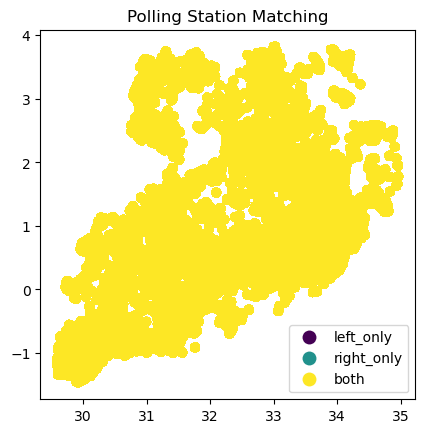

In [25]:
# Graphing voters unmatched with polling stations
merged_df2 = merged_df[merged_df["_merge"] == "both"]

ax3 = merged_df2.plot(column = "_merge",
                    cmap = "viridis",
                    legend = True,
                    missing_kwds={'color': 'lightgrey'})
ax3.set_title('Polling Station Matching')

In [26]:
joined_df2 = gpd.sjoin(districts, merged_df2, how = "left", op = "intersects")

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [27]:
joined_df2.head()

,dname2019,d,total2020,ttotal2020,2010,2016,2017,2018,2020,geometry,...,polling_station_num,sex,sub_county,sub_county_num,surname,village,voter_num,d_names,region,_merge
0,MASAKA,Masaka,"335,700",335700.0,MASAKA,MASAKA,MASAKA,MASAKA,MASAKA,"POLYGON ((32.00051 -0.60761, 32.00053 -0.60993...",...,5.0,M,MUKUNGWE,3.0,SSENTONGO,KALAGALA,59358180.0,Masaka,Buganda,both
0,MASAKA,Masaka,"335,700",335700.0,MASAKA,MASAKA,MASAKA,MASAKA,MASAKA,"POLYGON ((32.00051 -0.60761, 32.00053 -0.60993...",...,5.0,M,MUKUNGWE,3.0,SSENTONGO,LWABIKERE,63499503.0,Masaka,Buganda,both
0,MASAKA,Masaka,"335,700",335700.0,MASAKA,MASAKA,MASAKA,MASAKA,MASAKA,"POLYGON ((32.00051 -0.60761, 32.00053 -0.60993...",...,5.0,M,MUKUNGWE,3.0,SSENTONGO,KALAGALA,65273092.0,Masaka,Buganda,both
0,MASAKA,Masaka,"335,700",335700.0,MASAKA,MASAKA,MASAKA,MASAKA,MASAKA,"POLYGON ((32.00051 -0.60761, 32.00053 -0.60993...",...,5.0,M,MUKUNGWE,3.0,SSENUNGI,LWABIKERE,54986914.0,Masaka,Buganda,both
0,MASAKA,Masaka,"335,700",335700.0,MASAKA,MASAKA,MASAKA,MASAKA,MASAKA,"POLYGON ((32.00051 -0.60761, 32.00053 -0.60993...",...,5.0,M,MUKUNGWE,3.0,SSENYONDO,KALAGALA,51265629.0,Masaka,Buganda,both


In [28]:
both_count = joined_df2.groupby("2016")["2016"].count()
both_count.name = "both_count"
districts = pd.merge(left = districts, right = both_count, left_on = "2016", right_index = True)

0        Annotation(31.8556, -0.491258, 'MASAKA')
1          Annotation(33.9843, 1.18223, 'BUTEBO')
2        Annotation(33.2557, 2.26668, 'ALEBTONG')
3         Annotation(34.0822, 0.724974, 'TORORO')
4          Annotation(34.6316, 2.64869, 'MOROTO')
                          ...                    
124         Annotation(31.6614, -0.8062, 'RAKAI')
126       Annotation(31.3037, -0.707012, 'RAKAI')
125        Annotation(31.7027, 0.195672, 'GOMBA')
127    Annotation(30.1518, -0.483758, 'BUSHENYI')
128    Annotation(30.8777, -0.853239, 'ISINGIRO')
Length: 136, dtype: object

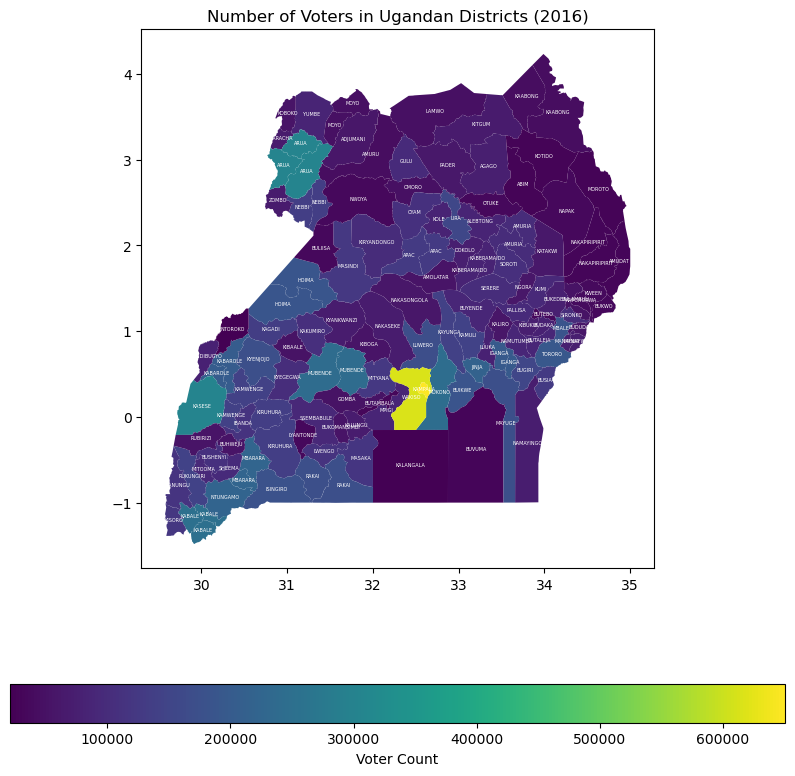

In [29]:
ax1 = districts.plot(column = "voter_count",
                    cmap = "viridis",
                    legend = True,
                    legend_kwds={'label': "Voter Count",
                                'orientation': "horizontal"},
                    figsize = (10,10))
ax1.set_title('Number of Voters in Ugandan Districts (2016)')
districts.apply(lambda x: ax1.annotate(text=x["2016"], xy = x.geometry.centroid.coords[0], ha = 'center', fontsize = 3.5, color = 'white'), axis = 1)

0        Annotation(31.8556, -0.491258, 'MASAKA')
1          Annotation(33.9843, 1.18223, 'BUTEBO')
2        Annotation(33.2557, 2.26668, 'ALEBTONG')
3         Annotation(34.0822, 0.724974, 'TORORO')
4          Annotation(34.6316, 2.64869, 'MOROTO')
                          ...                    
124         Annotation(31.6614, -0.8062, 'RAKAI')
126       Annotation(31.3037, -0.707012, 'RAKAI')
125        Annotation(31.7027, 0.195672, 'GOMBA')
127    Annotation(30.1518, -0.483758, 'BUSHENYI')
128    Annotation(30.8777, -0.853239, 'ISINGIRO')
Length: 136, dtype: object

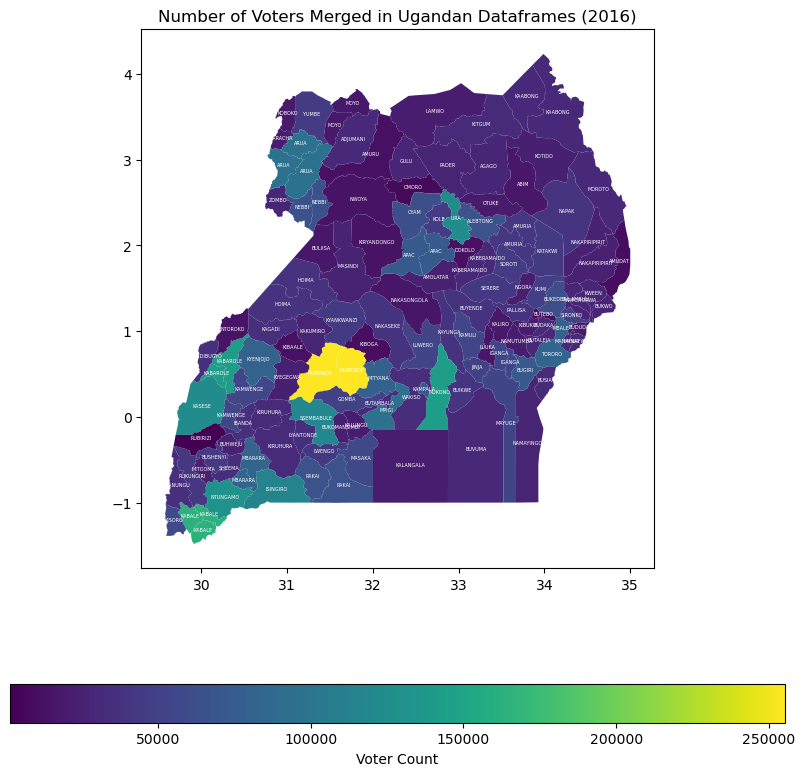

In [30]:
# Graph number of voters successfully merged
ax4 = districts.plot(column = "both_count",
                    cmap = "viridis",
                    legend = True,
                    legend_kwds={'label': "Voter Count",
                                'orientation': "horizontal"},
                    figsize = (10,10))
ax4.set_title('Number of Voters Merged in Ugandan Dataframes (2016)')
districts.apply(lambda x: ax4.annotate(text=x["2016"], xy = x.geometry.centroid.coords[0], ha = 'center', fontsize = 3.5, color = 'white'), axis = 1)

## Machine Learning

In [31]:
# Sample data frame
df_sample = joined_df2.sample(10000)

In [32]:
# Change from geographic to projected
df_sample = df_sample.to_crs("EPSG:3857")

In [33]:
# Find centroid of geometries
df_sample['x_coord'] = df_sample.centroid.x
df_sample['y_coord'] = df_sample.centroid.y

In [34]:
# Create train-test split
feature_pipeline = Pipeline(
    [
        ('tfidf', TfidfVectorizer(ngram_range = (1,3), analyzer='char_wb', lowercase=False, min_df=3)),
    ]
)

labels = LabelEncoder()

X_train, X_test, y_train, y_test = train_test_split(
    df_sample['surname'], df_sample[['x_coord', 'y_coord']], random_state=8, test_size=.3
)

feature_pipeline.fit(X_train)

X_train = feature_pipeline.transform(X_train)
X_test = feature_pipeline.transform(X_test)

In [35]:
# Fit ElasticNet model
model = ElasticNet()

model.fit(X_train.toarray(), y_train)

ElasticNet()

In [36]:
# Find R^2 for training data
model.score(X_train, y_train)

0.01922097611782425

In [37]:
# Find R^2 for test data
model.score(X_test, y_test)

0.019068483116488677

In [38]:
# Duplicate dataframe
df_sample1 = df_sample

In [40]:
# Convert 'lat_lon' column to separate 'lat' and 'lon' columns
lat = []
lon = []

for x in df_sample1['lat_lon']:
    lat.append(x[0])
    lon.append(x[1])

df_sample1['lat'] = lat
df_sample1['lon'] = lon

In [41]:
# Create train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    df_sample1['surname'], df_sample1[['lat', 'lon']], random_state=8, test_size=.3
)

feature_pipeline.fit(X_train1)

X_train1 = feature_pipeline.transform(X_train1)
X_test1 = feature_pipeline.transform(X_test1)

In [42]:
# Fit ElasticNet model
model1 = ElasticNet()

model1.fit(X_train1.toarray(), y_train1)

ElasticNet()

In [43]:
# Find R^2 for training data
model1.score(X_train1, y_train1)

-2.6645352591003757e-15

In [44]:
# Find R^2 for test data
model1.score(X_test1, y_test1)

-2.7198354955904058e-05

## Concerns

The scores for the model are quite low. Did I make a mistake with the model, or is this part of a larger issue? For example, most of our successfully merged voters are in the populous south/west of Uganda. Here, surnames might be more geographically interspersed, which would affect our model's predictive ability.

## Machine Learning, Take Two

In [45]:
# Find length before dropping regions
len(joined_df2)

5262715

In [46]:
# Drop Wakiso and Kampala
joined_df3 = joined_df2[joined_df2["2016"] != "WAKISO"]
joined_df3 = joined_df3[joined_df3["2016"] != "KAMPALA"]
len(joined_df3)

5158864

In [47]:
# Conduct group_by sample
df_sample2 = joined_df3.groupby("region").sample(8000, random_state = 8)

In [48]:
# See length of dataframe
len(df_sample2)

120000

In [49]:
# Convert 'lat_lon' column to separate 'lat' and 'lon' columns
lat = []
lon = []

for x in df_sample2['lat_lon']:
    lat.append(x[0])
    lon.append(x[1])

df_sample2['lat'] = lat
df_sample2['lon'] = lon

In [50]:
# Create train-test split
feature_pipeline = Pipeline(
    [
        ('tfidf', TfidfVectorizer(ngram_range = (1,3), analyzer='char_wb', lowercase=False, min_df=3)),
    ]
)

labels = LabelEncoder()

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df_sample2['surname'], df_sample2[['lat', 'lon']], random_state=8, test_size=.3
)

feature_pipeline.fit(X_train2)

X_train2 = feature_pipeline.transform(X_train2)
X_test2 = feature_pipeline.transform(X_test2)

In [51]:
# Fit ElasticNet model
model2 = ElasticNet()

model2.fit(X_train2.toarray(), y_train2)

ElasticNet()

In [52]:
# Find R^2 for training data
model2.score(X_train2, y_train2)

-6.661338147750939e-16

In [53]:
# Find R^2 for test data
model2.score(X_test2, y_test2)

-6.481782464540231e-06

In [56]:
# Saving model
file = 'zhang_polling_station.sav'
joblib.dump(model2, open(file, 'wb'))